## Student Name: Brian Mortimer
## Student ID: 20258763

In [36]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE

from sklearn.cluster import DBSCAN


In [2]:
# Load data (bank.csv)
original_df = pd.read_csv("bank.csv")

In [3]:
original_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [4]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1988 non-null   float64
 1   job         1990 non-null   object 
 2   marital     2000 non-null   object 
 3   education   1896 non-null   object 
 4   default     2000 non-null   object 
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   object 
 7   loan        2000 non-null   object 
 8   contact     1809 non-null   object 
 9   day         2000 non-null   int64  
 10  month       2000 non-null   object 
 11  duration    2000 non-null   int64  
 12  campaign    2000 non-null   int64  
 13  pdays       2000 non-null   int64  
 14  previous    2000 non-null   int64  
 15  poutcome    1546 non-null   object 
 16  subscribed  2000 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 265.8+ KB


# Task 1: Data Preparation Pipeline

Open a new Jupyter notebook and name it etivity2.ipynb. In this notebook, create a data preparation pipeline that applies the same kind of transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

In [19]:
# Copy the original dataframe
df = original_df.copy()

In [20]:
# Fill null values with unknown 
df.fillna({'job':"unknown", "education": "unknown", "poutcome": "unknown"}, inplace=True)

In [21]:
# Drop the rows with null age values
df.dropna(subset=['age'], inplace=True)

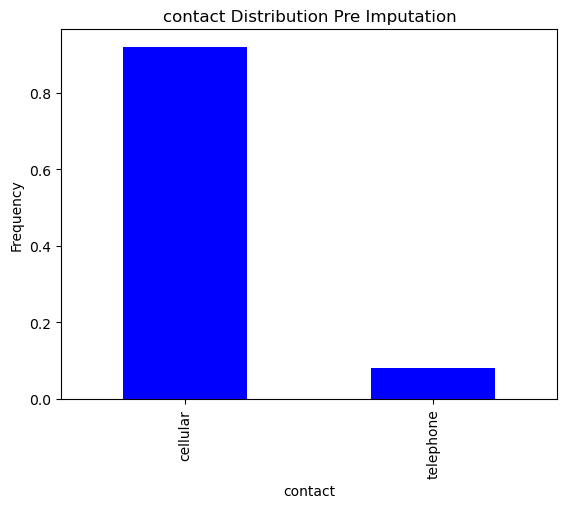

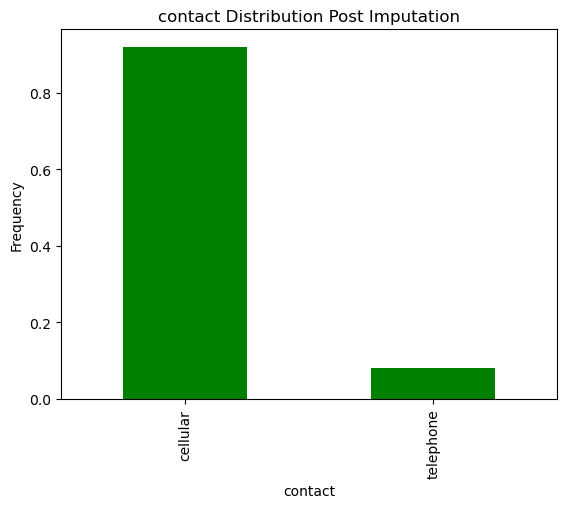

In [22]:
def impute_df_col(df, col):
    """
    Function to impute missing values in a dataframe column
    """

    # Get the distribution of the col (excluding missing values)
    col_distribution = df[col].value_counts(normalize=True)

    # Define a function to randomly sample based on the distribution
    def impute_job_with_distribution(row):
        if pd.isnull(row[col]):
            return np.random.choice(col_distribution.index, p=col_distribution.values)
        return row[col]

    col_distribution.plot(kind='bar', color='blue')
    plt.title(f'{col} Distribution Pre Imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    # Impute missing values in col using the distribution
    df[col] = df.apply(impute_job_with_distribution, axis=1)

    # Plot the distribution after imputation
    col_distribution_after = df[col].value_counts(normalize=True)
    col_distribution_after.plot(kind='bar', color='green')
    plt.title(f'{col} Distribution Post Imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
# Impute the contact column
impute_df_col(df, 'contact')

In [23]:
# Check for null values
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

In [24]:
# Convert cyclical features for month and day
month_map = {
    'jan': 0,
    'feb': 1,
    'mar': 2,
    'apr': 3,
    'may': 4,
    'jun': 5,
    'jul': 6,
    'aug': 7,
    'sep': 8,
    'oct': 9,
    'nov': 10,
    'dec': 11
}

df['month_num'] = df['month'].map(month_map)
months_in_year = 12
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / months_in_year)

months_days = {
    'jan': 31,
    'feb': 28,
    'mar': 31,
    'apr': 30,
    'may': 31,
    'jun': 30,
    'jul': 31,
    'aug': 31,
    'sep': 30,
    'oct': 31,
    'nov': 30,
    'dec': 31
}

df['max_days'] = df['month'].map(months_days)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / df['max_days'])
df['day_cos'] = np.cos(2 * np.pi * df['day'] / df['max_days'])

# Remove unnecessary columns
df = df.drop(columns=['max_days', "month_num"], axis=1)

In [25]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,subscribed,month_sin,month_cos,day_sin,day_cos
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,...,957,2,131,2,failure,no,1.0,6.123234e-17,0.207912,0.978148
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,...,233,2,133,1,failure,no,1.0,6.123234e-17,0.207912,0.978148
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,...,126,2,239,1,failure,no,1.0,6.123234e-17,0.207912,0.978148
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,...,274,1,238,2,failure,no,1.0,6.123234e-17,0.207912,0.978148
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,...,479,1,307,1,failure,no,1.0,6.123234e-17,0.207912,0.978148


In [26]:
# Create the pipeline for preprocessing
set_config(display='diagram')

# Define the categorical numerical, cyclical and ordinal columns
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', "month_sin", "month_cos", "day_sin", "day_cos"]
cyclical_cols = ['day', 'month']


# Create the categorical transformer
cat_transformer = Pipeline(steps=[
    ('onehot', FunctionTransformer(lambda x: pd.get_dummies(x, drop_first=True), validate=False))
])

# Create the numerical transformer
num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
        ('num', num_transformer, num_cols)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

In [27]:
# Fit the pipeline to the data
pipeline.fit(df)

# Transform the data
X_transformed = pipeline.transform(df)

In [30]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Task 2: k-Means

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
- Use the Silhouette Coefficient method to determine the best value of k as well.
- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
- Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

c:\Users\morti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\morti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\morti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\morti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\morti\anaconda3\lib\site-packages\sklearn\clust

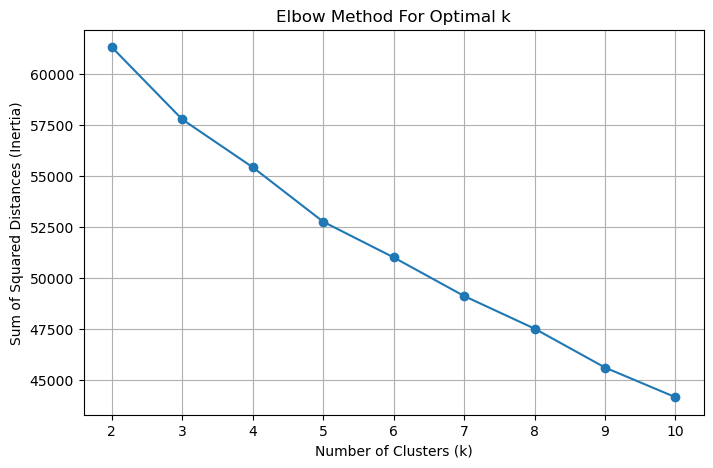

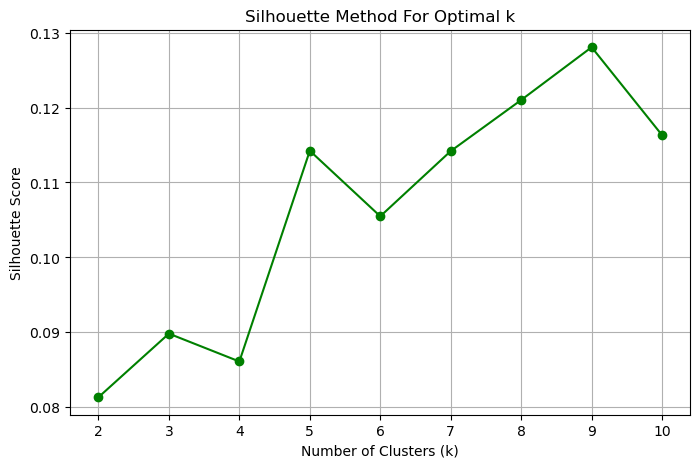

In [32]:
# Plot the sum of squared distances from the data points in the bank dataset to the centers of the k-means cluster for various values of k and use the elbow method to pick the best k value.

def plot_K_values(X, max_k=12):
    """
    Plot the elbow method for k-means clustering.
    
    Parameters:
    X (array-like): The input data.
    max_k (int): The maximum number of clusters to test.
    
    Returns:
    None
    """
    k_range = range(2, max_k + 1)
    sse = []
    silhouette_scores = []
    
    
    for k in k_range:
        k_means = KMeans(n_clusters=k, random_state=42)
        k_means.fit(X)
        sse.append(k_means.inertia_)

    for k in k_range:
        k_means = KMeans(n_clusters=k, random_state=42)
        labels = k_means.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        
    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, silhouette_scores, marker='o', color='green')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.grid(True)
    plt.show()

# Call the function to plot the elbow method and silhouette scores
plot_K_values(X_scaled, max_k=10)

In [45]:
best_k = 5

k_means = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = k_means.fit_predict(X_scaled)

df['cluster'] = cluster_labels

c:\Users\morti\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\morti\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


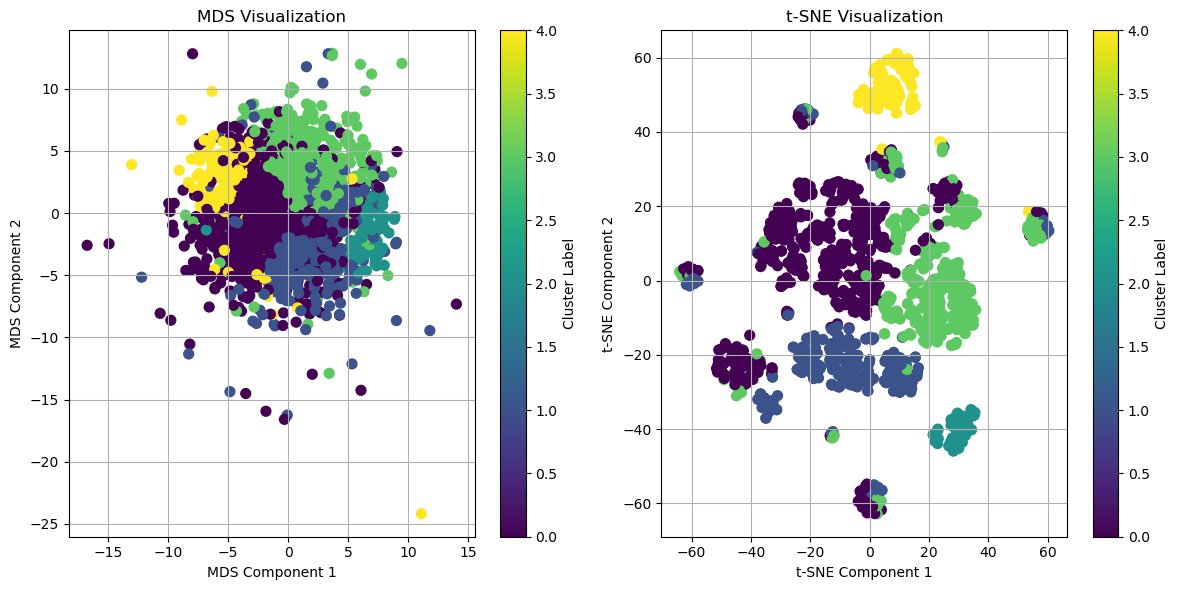

In [46]:
# Visualize MDS and t-SNE
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

def plot_mds_tsne(X_mds, X_tsne, cluster_labels):
    """
    Plot MDS and t-SNE visualizations.

    Parameters:
    X_mds (array-like): MDS transformed data.
    X_tsne (array-like): t-SNE transformed data.
    cluster_labels (array-like): Cluster labels.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))

    # MDS plot
    plt.subplot(1, 2, 1)
    plt.scatter(X_mds[:, 0], X_mds[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title('MDS Visualization')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.colorbar(label='Cluster Label')
    plt.grid(True)

    # t-SNE plot
    plt.subplot(1, 2, 2)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Cluster Label')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_mds_tsne(X_mds, X_tsne, cluster_labels)

In [44]:
df["cluster"].value_counts()

1    645
2    464
3    452
0    427
Name: cluster, dtype: int64

# Task 3: DBSCAN

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.
- Use MDS and t-SNE for visualising the clustering. Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

In [39]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

df['dbscan_cluster'] = dbscan_labels

c:\Users\morti\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


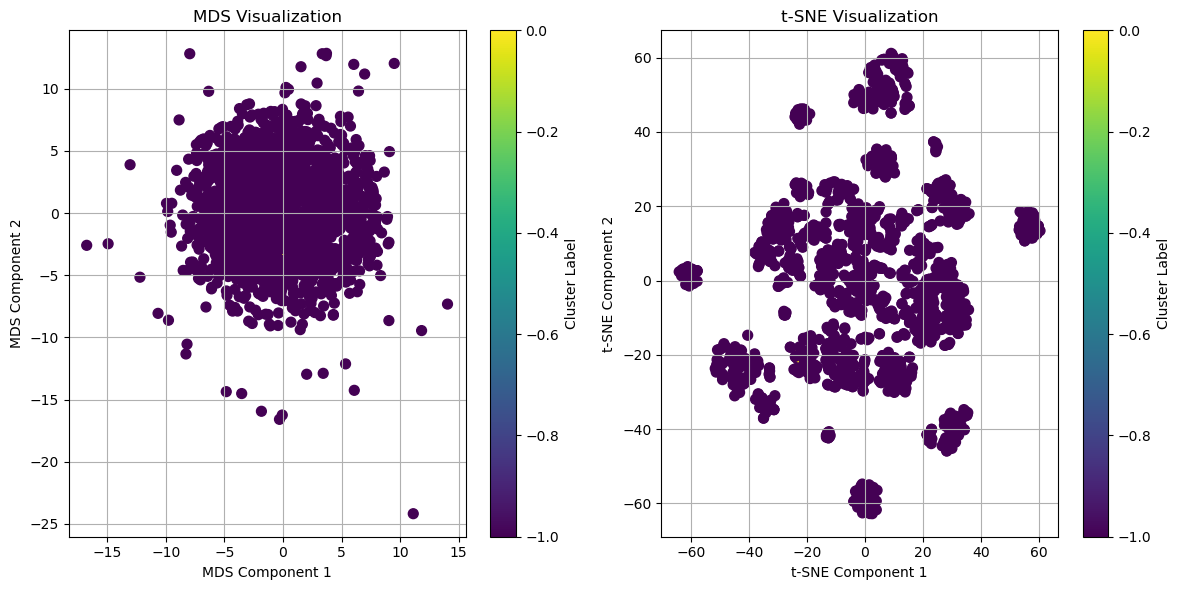

In [40]:
X_mds = mds.fit_transform(X_scaled)
X_tsne = tsne.fit_transform(X_scaled)

# Plot MDS and t-SNE with DBSCAN clusters
plot_mds_tsne(X_mds, X_tsne, dbscan_labels)

In [41]:
df["dbscan_cluster"].value_counts()

-1    1981
 0       7
Name: dbscan_cluster, dtype: int64

# Conclusion